In [11]:
import seaborn as sns

from work.luther_code import read_pickle

In [8]:
df = read_pickle('data/merged_data_df.pickle')
df.drop(columns=['Name', 'Team', 'Games_Played', 'Birth_Date', 'Nationality'], inplace=True)

In [10]:
df.corr()

,Time_On_Ice,Points,Shots,Penalty_Minutes,Major_Penalties,Penalties_Drawn,Hits,Hits_Taken,Shots_Blocked,Season,Height,Weight,European,Russian,Games_Missed,Age,Last_Games_Missed,Avg_Games_Missed
Time_On_Ice,1.000000,0.573870,0.603645,-0.036736,-0.218193,0.097647,0.105511,0.427519,0.600560,0.021065,0.060486,0.059523,0.107936,0.025484,0.106625,0.138198,0.103171,0.128374
Points,0.573870,1.000000,0.765237,-0.060774,-0.174118,0.224403,-0.115531,0.088653,-0.014765,0.024609,-0.095510,-0.083057,0.093556,0.057781,0.051676,0.063531,0.048531,0.086205
Shots,0.603645,0.765237,1.000000,-0.057445,-0.189296,0.239032,-0.005234,0.183549,0.001456,0.033392,-0.075368,-0.049561,0.082390,0.032231,0.062024,0.033674,0.059158,0.089884
Penalty_Minutes,-0.036736,-0.060774,-0.057445,1.000000,0.754282,0.516847,0.327249,0.054343,0.004963,-0.126861,0.178609,0.263596,-0.105883,-0.042630,0.040594,0.088159,0.025297,0.025955
Major_Penalties,-0.218193,-0.174118,-0.189296,0.754282,1.000000,0.485181,0.241273,-0.043978,-0.081540,-0.114938,0.133811,0.207579,-0.132527,-0.054539,0.007515,0.039432,-0.014768,-0.020888
Penalties_Drawn,0.097647,0.224403,0.239032,0.516847,0.485181,1.000000,0.243090,0.121559,-0.094564,-0.126934,-0.020808,0.049957,-0.064148,-0.007808,0.061121,-0.014778,0.016620,0.030782
Hits,0.105511,-0.115531,-0.005234,0.327249,0.241273,0.243090,1.000000,0.290019,0.169339,0.011093,0.196935,0.336614,-0.102461,-0.040059,0.047569,0.020957,0.028263,0.021585
Hits_Taken,0.427519,0.088653,0.183549,0.054343,-0.043978,0.121559,0.290019,1.000000,0.369705,0.010601,0.052007,0.039485,0.042977,-0.006290,0.054144,-0.072341,0.033077,0.033972
Shots_Blocked,0.600560,-0.014765,0.001456,0.004963,-0.081540,-0.094564,0.169339,0.369705,1.000000,0.028126,0.159670,0.158498,0.015490,-0.027412,0.079908,0.121321,0.082634,0.093759
Season,0.021065,0.024609,0.033392,-0.126861,-0.114938,-0.126934,0.011093,0.010601,0.028126,1.000000,-0.025979,-0.116066,0.038084,0.023495,0.020694,-0.054838,0.078131,0.057182


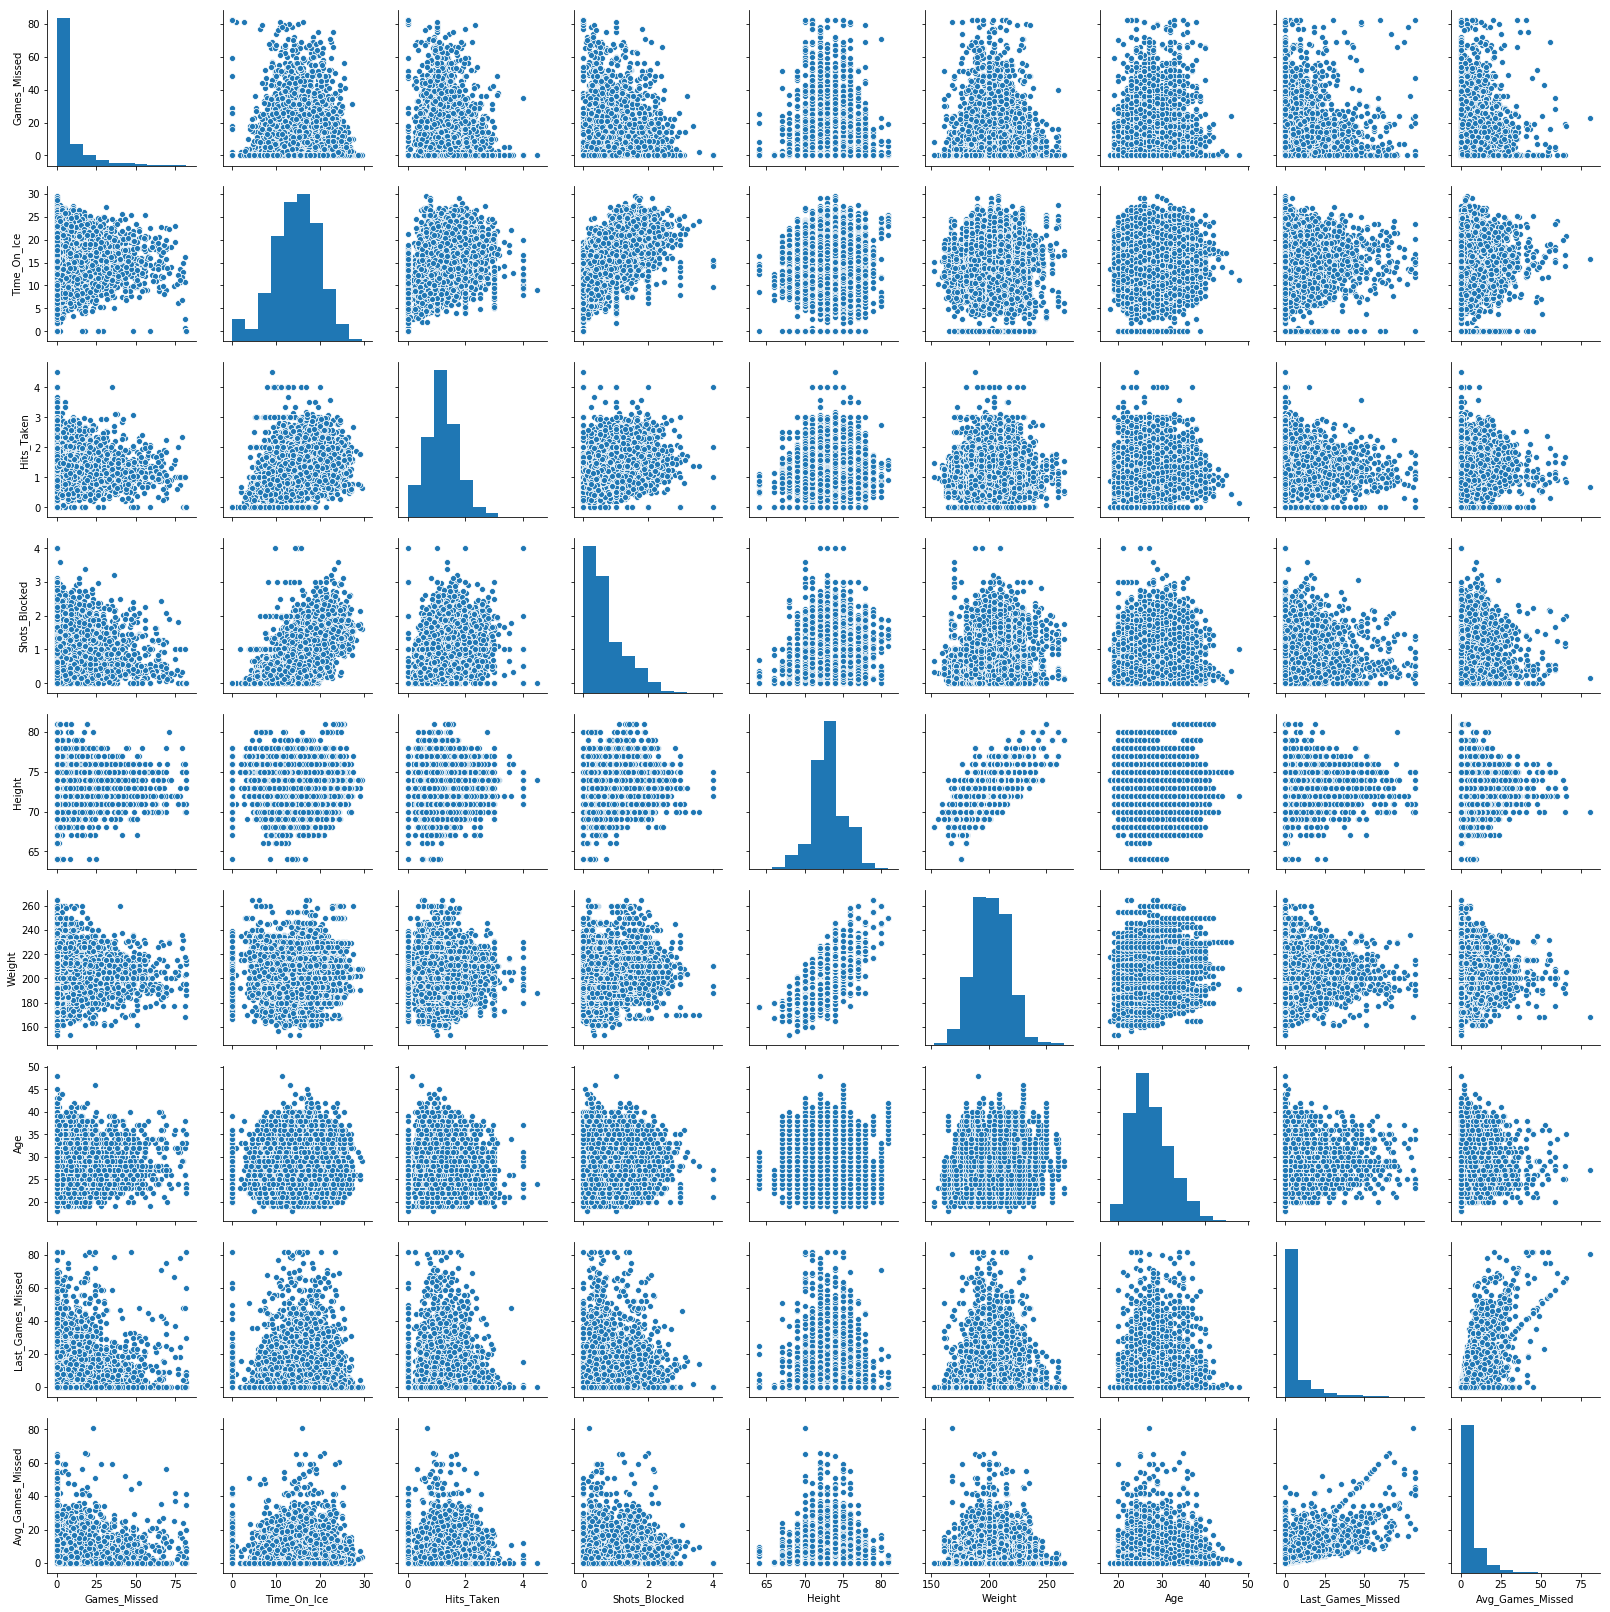

In [13]:
subset = ['Games_Missed', 'Time_On_Ice', 'Hits_Taken', 'Shots_Blocked', 'Height', 'Weight',
          'Age', 'Last_Games_Missed', 'Avg_Games_Missed']
sns.pairplot(df[subset]);